In [22]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx


from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *

# white grid
sns.set_style("whitegrid")


In [23]:

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:

PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')




In [25]:

df = text_embeddings_metadata_results_preprocessing(df, models=MODELS_MAIN_EXPES)
METRIC = "I(X_1->X_2)/d_2"


In [37]:

classifcation_df = pd.read_csv('exported_data/classification_many_2.csv')

classifcation_df['model'] = classifcation_df['model'].apply(lambda x: eval(x)[0])

rankings = make_rankings_table(classifcation_df, df, METRIC, q=0.5)

rankings['model'] = map_short(rankings['model'].tolist())


/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table = (


In [38]:


print(len(df['model_1'].unique().tolist()))

34


In [39]:

print(" ".join([f'"{m}"' for m in df['model_1'].unique().tolist()]))



"BAAI/bge-base-en-v1.5" "GritLM/GritLM-7B" "NousResearch/Llama-2-7b-hf" "Salesforce/SFR-Embedding-Mistral" "SmartComponents/bge-micro-v2" "TaylorAI/gte-tiny" "WhereIsAI/UAE-Large-V1" "avsolatorio/GIST-Embedding-v0" "google/gemma-2b-it" "google/gemma-7b-it" "infgrad/stella-base-en-v2" "intfloat/e5-large-v2" "intfloat/e5-small" "intfloat/multilingual-e5-small" "izhx/udever-bloom-560m" "jamesgpt1/sf_model_e5" "jspringer/echo-mistral-7b-instruct-lasttoken" "llmrails/ember-v1" "princeton-nlp/sup-simcse-bert-base-uncased" "sentence-transformers/LaBSE" "sentence-transformers/all-MiniLM-L6-v2" "sentence-transformers/all-distilroberta-v1" "sentence-transformers/all-mpnet-base-v2" "sentence-transformers/allenai-specter" "sentence-transformers/average_word_embeddings_glove.6B.300d" "sentence-transformers/average_word_embeddings_komninos" "sentence-transformers/gtr-t5-base" "sentence-transformers/gtr-t5-large" "sentence-transformers/gtr-t5-xl" "sentence-transformers/msmarco-bert-co-condensor" "sen

/tmp/ipykernel_244011/1602465474.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax['ranking_classif'].set_yticklabels(ax['ranking_classif'].get_yticklabels(), fontsize=18, fontweight='bold')


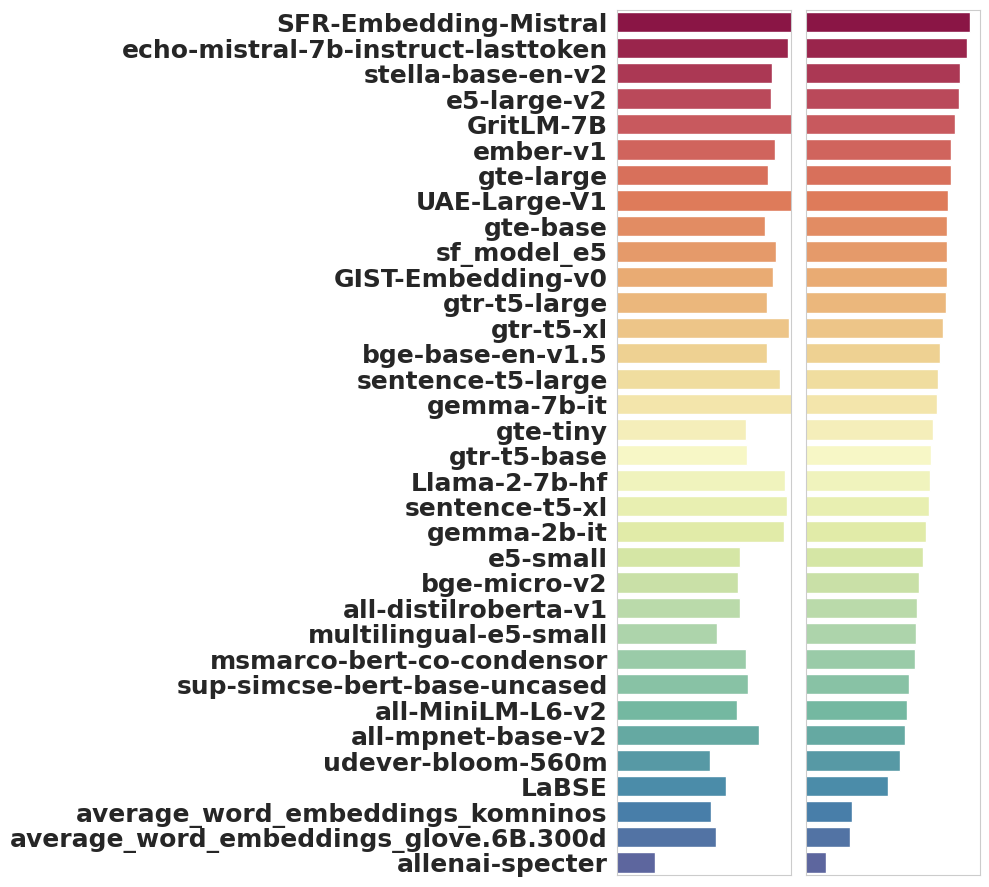

In [47]:


fig, ax = plt.subplot_mosaic([['ranking_classif', 'ranking_informativeness']], sharey=True, sharex=False, figsize=(10, 9))
# hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']*2

informativeness_ranking = rankings[rankings['ranking'] == 'informativeness']
classification_ranking = rankings[rankings['ranking'] == 'classification']

# rank both by informativeness
ordered_models = informativeness_ranking.sort_values('value', ascending=False)['model'].values

spectral_cmap = sns.color_palette("Spectral", as_cmap=True)
model_colors = {m : k for k, m in enumerate(ordered_models)}
# normalize colors
model_colors = {m: spectral_cmap(k / len(model_colors)) for m, k in model_colors.items()}


informativeness_ranking = informativeness_ranking.set_index('model').loc[ordered_models].reset_index()
classification_ranking = classification_ranking.set_index('model').loc[ordered_models].reset_index()

sns.barplot(data=informativeness_ranking, y='model', x='value', ax=ax['ranking_informativeness'], palette=model_colors, orient='h', hue='model')
ax['ranking_informativeness'].set_xlim(0.35, 0.6)
# remove ticks
ax['ranking_informativeness'].set_xticks([])
ax['ranking_informativeness'].set_xlabel('')
ax['ranking_informativeness'].set_ylabel('')


sns.barplot(data=classification_ranking, y='model', x='value', ax=ax['ranking_classif'], palette=model_colors, orient='h', hue='model')
ax['ranking_classif'].set_xlim(0.5, 0.70)
# remove ticks
ax['ranking_classif'].set_xticks([])
ax['ranking_classif'].set_xlabel('')
ax['ranking_classif'].set_ylabel('')

ax['ranking_classif'].set_yticklabels(ax['ranking_classif'].get_yticklabels(), fontsize=18, fontweight='bold')

fig.tight_layout()

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_barplot_rankings_mytasks_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')




Index(['model', 'value', 'rank', 'ranking', 'community'], dtype='object')


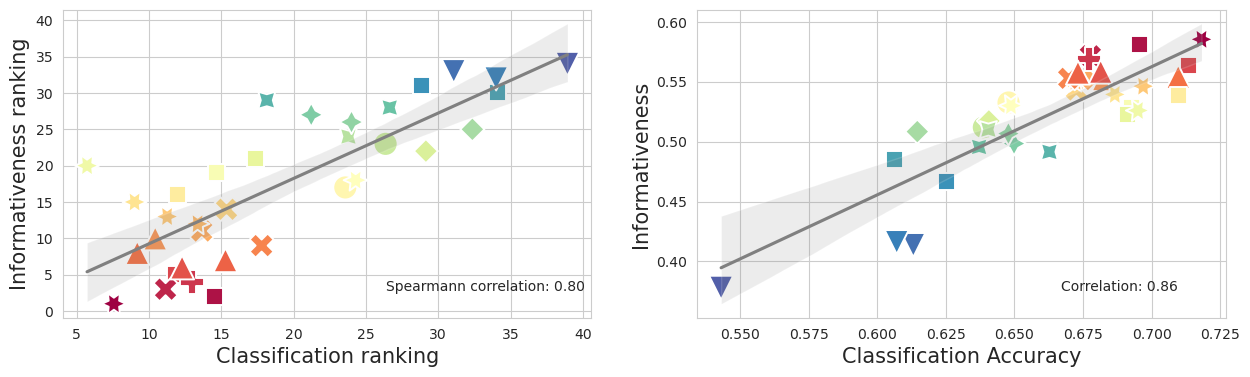

In [30]:
print(rankings.columns)

fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

scattering_pivot = rankings.groupby(['model', 'ranking', 'community']).first().reset_index().pivot(columns='ranking', values='rank', index=['model', 'community']) # classification, informativeness

# fillna
scattering_pivot = scattering_pivot.fillna(0)

sns.scatterplot(data=scattering_pivot, x='classification', y='informativeness', ax=ax[0], hue="model", style="community", legend=False, s=300, palette=model_colors)

sns.regplot(data=scattering_pivot, x='classification', y='informativeness', ax=ax[0], scatter=False, color='gray')

# rename labels
ax[0].set_xlabel('Classification ranking', fontsize=15)
ax[0].set_ylabel('Informativeness ranking', fontsize=15)

# annotate with spearmann correlation
corr = scattering_pivot.corr().loc['classification', 'informativeness']
ax[0].annotate(f"Spearmann correlation: {corr:.2f}", (0.8, 0.1), xycoords='axes fraction', ha='center', va='center')



###########
# Plot correlations with accuracy
###########

scattering_pivot = rankings.groupby(['model', 'ranking', 'community']).first().reset_index().pivot(columns='ranking', values='value', index=['model', 'community']) # classification, informativeness

# fillna
scattering_pivot = scattering_pivot.fillna(0)

sns.scatterplot(data=scattering_pivot, x='classification', y='informativeness', ax=ax[1], hue="model", style="community", legend=False, s=300, palette=model_colors)

sns.regplot(data=scattering_pivot, x='classification', y='informativeness', ax=ax[1], scatter=False, color='gray')

# rename labels
ax[1].set_xlabel('Classification Accuracy', fontsize=15)
ax[1].set_ylabel('Informativeness', fontsize=15)

# annotate with spearmann correlation
corr = scattering_pivot.corr().loc['classification', 'informativeness']
ax[1].annotate(f"Correlation: {corr:.2f}", (0.8, 0.1), xycoords='axes fraction', ha='center', va='center')



path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_scatterplot_rankings_mytasks_{sanitize_metric_name(METRIC)}.pdf")
path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(path, bbox_inches='tight')





In [31]:
# barplot of performance by community


rankings_per_task = make_rankings_table(classifcation_df, df, METRIC, aggrefate_tasks=False)

rankings_per_task = rankings_per_task[['model', 'dataset', 'value', 'ranking', 'rank', 'community']]




/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  table = (


In [32]:

# select all not NaN datasets
rankings_per_task_classif = rankings_per_task[~rankings_per_task['dataset'].isna()]
informativeness = rankings_per_task[rankings_per_task['ranking'] == 'informativeness']

correlation_table = []
for dataset in rankings_per_task_classif['dataset'].unique():
    print(dataset)
    selected_ds_classif = rankings_per_task_classif[rankings_per_task_classif['dataset'] == dataset]
    
    temp = pd.concat([selected_ds_classif, informativeness])
    
    # pivot table, ranking
    temp_values = temp.pivot(columns='ranking', values='value', index=['model', 'community'])
    temp_ranking = temp.pivot(columns='ranking', values='rank', index=['model', 'community'])
    
    
    correlation_table.append({
        'dataset': dataset,
        'Pearson': temp_values.corr().loc['classification', 'informativeness'],
        'Spearmann': temp_ranking.corr().loc['classification', 'informativeness'],
        'Kendall': temp_values.corr(method='kendall').loc['classification', 'informativeness'],
    })
    
correlation_table = pd.DataFrame(correlation_table)

dair-ai/emotion
paws-x;en
rotten_tomatoes
sst2
tweet_eval;emoji
tweet_eval;emotion
tweet_eval;sentiment
clinc_oos;plus


In [33]:
correlation_table

,dataset,Pearson,Spearmann,Kendall
0,dair-ai/emotion,0.745080,0.793711,0.587656
1,paws-x;en,0.281536,0.283007,0.171582
2,rotten_tomatoes,0.870775,0.834010,0.635147
3,sst2,0.852959,0.766442,0.580358
4,tweet_eval;emoji,0.358614,0.416316,0.301248
5,tweet_eval;emotion,0.744562,0.584381,0.403212
6,tweet_eval;sentiment,0.818196,0.554185,0.394643
7,clinc_oos;plus,0.801495,0.714149,0.444444
